Pipeline of our model:
<br><img src="plots/demo.png" width="500"><br>

In [1]:
import numpy as np
from IPython.display import SVG, display

import sys
sys.path.append('/nfs/turbo/lsa-enes/bim/bim/')# you should have this package on the sys.path

from utils import segsites_to_trees

In [2]:
from Bimbalance import bSFS, bTree

# Basic Usage

In [3]:
# genotype matrix:
GM = np.array([[1, 0, 0, 1, 1, 1, 0],
               [1, 0, 0, 1, 1, 1, 1],
               [1, 0, 0, 1, 1, 0, 0],
               [0, 1, 1, 1, 0, 0, 0],
               [0, 1, 0, 0, 0, 0, 0]]).T
# 7 sites for 5 individuals
N = GM.shape[1]
L = GM.shape[0]

## Method 1: Infer  $\beta$-splitting by SFS

In [4]:
bsfs = bSFS(N, rho1 = 0.01, rho2 = 0.01) # load the object for penalized MLE

In [5]:
sfs = bsfs.segsites_to_SFS(GM) # Genotype Matrix -> sfs
betasfs_out = bsfs.predict(sfs) # this is where the optimization happens

In [6]:
betasfs_out

     fun: 2.5188829689045167
     jac: array([-1.10539251e-05])
 message: 'Optimization terminated successfully.'
    nfev: 6
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.70801823])

## Method 2: Infer  $\beta$-splitting by tree split sizes

In [7]:
inferred_ts = segsites_to_trees(GM) # infer trees from genotype matrix by tsinfer

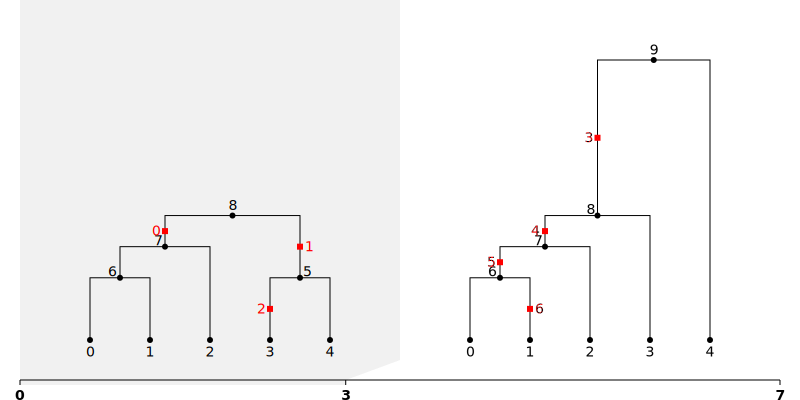

In [8]:
SVG(inferred_ts.draw_svg(size=(800, 400)))

In [9]:
btree = bTree(N, rho1 = 0.005, rho2 = 0.005) # load the object for penalized MLE

In [10]:
t = 0
for tree in inferred_ts.trees():
    print(tree.interval)
    out = btree.split_predict(tree) # this is where the optimization happens
    print(out)    
    left, right = tree.interval
    t += (right-left)*out.x[0]
    print(20*'--')
print('\nweighted avarage for the region is = ', t/inferred_ts.get_sequence_length())    

Interval(left=0.0, right=3.0)
     fun: 0.48701185253075774
     jac: array([1.09741211e-05])
 message: 'Optimization terminated successfully.'
    nfev: 7
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([2.07565359])
----------------------------------------
Interval(left=3.0, right=7.0)
     fun: 0.7596626274584588
     jac: array([1.03469797e-05])
 message: 'Optimization terminated successfully.'
    nfev: 7
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([-1.81183916])
----------------------------------------

weighted avarage for the region is =  -0.14577083689387774


# Advanced Usage

In this example we only have biallelic genotype matrix (`GM`) with the mutation positions (`pos`). I load them from the `.trees` file, but it's not neccessary. It can be loaded from anywhere but the data should be in following format; `GM` should be a size `LxN` numpy array where `L` is number of segrating sites and `N` is the sample size. And `pos` should be a vector of size `L`. I calculate genome-scan values of beta-splitting.

In [3]:
import tskit
ts = tskit.load('example.trees')

In [4]:
GM = ts.genotype_matrix()
GM.shape

(30057, 250)

In [5]:
pos = [i.position for i in list(ts.mutations())]
len(pos)

30057

## Method 1: Infer  $\beta$-splitting by SFS

### Estimate effective population size with the built-in optimizer

In [6]:
import numpy as np
from utils import InferEta
from Bimbalance import PConst
import matplotlib.pyplot as plt

In [7]:
t = np.logspace(np.log10(1), np.log10(100000), 20)
t = np.concatenate((np.array([0]), t)) # breakpoints for the time (by generations)

a1 = 0. #sequential l1 penalty 
a2 = 1e1 #sequential l2 penalty

In [8]:
N = GM.shape[1]
bsfs = bSFS(N)

In [9]:
SFS = bsfs.segsites_to_SFS(GM) # chromosome-wide SFS
inferEta = InferEta(N, t, a1 = a1, a2 = a2)
etaout = inferEta.predict(SFS, maxiter = 1000)

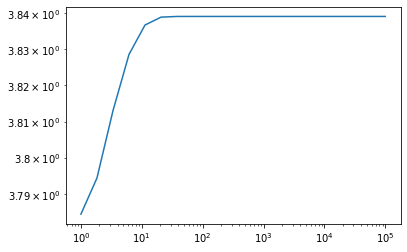

In [10]:
ePS = etaout.x
plt.plot(t[1:], ePS[:-1])
plt.yscale('log')
plt.xscale('log')

note: The true population size history is constant. But we assume, we do not know the true one and use the estimated one. One can also give a pre-defined piecewise constant size history.

### Genome-scan for beta-splitting using genotype matrix and mutation positions

In [60]:
eta = PConst(t = t, a = 1/ePS) # create population size history object
bsfs = bSFS(N, eta = eta, rho2 = 0.05) # load the bsfs with the spesified size history (this could take some time to compile)

In [61]:
window_size = 25000 # disjoint window size

In [62]:
end = window_size
nmut = len(pos)

beta = []

cur = []
for i in range(nmut): 
    if pos[i]>end:
        sfs = bsfs.segsites_to_SFS(GM[cur])
        beta.append(bsfs.predict(sfs).x[0])
        cur = []
        end += window_size
        
    cur.append(i)

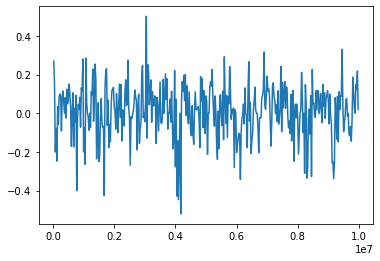

In [63]:
plt.plot(np.arange(window_size, end, window_size), beta)

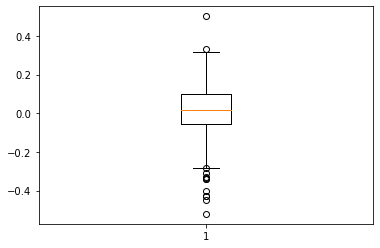

In [64]:
plt.boxplot(beta)
plt.show()

## Method 2: Infer  $\beta$-splitting by trees

In [66]:
inferred_ts = segsites_to_trees(GM) # infer trees from genotype matrix by tsinfer

In [67]:
btree = bTree(N, rho2 = 0.01) 

In [69]:
trees = inferred_ts.trees()

betatree = []
while(1):
    try:
        Tree = next(trees)
    except:
        break
    start, end = Tree.interval
    res = {'start':start, 'end':end}
    n, k = btree.tree_to_splits(Tree)['splits'] # tree -> splits
    res['btree'] = btree.predict(n, k, n-2).x[0] # splits -> betahat
    betatree.append(res)

Tree sequences have non-fixed spans that is constructed by tsinfer. 

In [72]:
pos_end = [i['start'] for i in betatree]
beta = [i['btree'] for i in betatree]

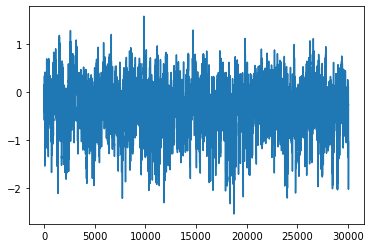

In [73]:
plt.plot(pos_end, beta)

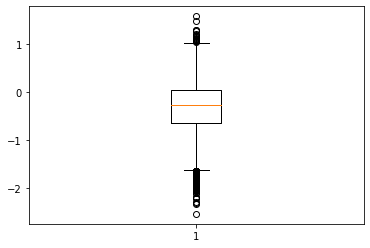

In [74]:
plt.boxplot(beta)
plt.show()